# Models

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import json

import tensorflow as tf

from keras.layers import Conv2D, UpSampling2D, Dense, MaxPooling2D, BatchNormalization, Conv2DTranspose
from keras.models import Sequential

import random

In [115]:
seed = 42
random.seed(seed)
dataset_path = "../preprocessed/"
dataset = "tiny-imagenet-200/"
path = '../dataset/'
models_path = "../models/"
history_path = "../models/history/"

In [116]:
SIZE = 128

In [117]:
X_train = np.load('../preprocessed/'+dataset+'x_train.npy')
Y_train = np.load('../preprocessed/'+dataset+'y_train.npy')

X_valid = np.load('../preprocessed/'+dataset+'x_valid.npy')
Y_valid = np.load('../preprocessed/'+dataset+'y_valid.npy')

X_test = np.load('../preprocessed/'+dataset+'x_test.npy')
Y_test = np.load('../preprocessed/'+dataset+'y_test.npy')

In [118]:
print(f"{len(X_train)} training examples")
print(f"{len(X_valid)} validation examples")
print(f"{len(X_test)} test examples")

16000 training examples
4000 validation examples
5000 test examples


## CNN

In [119]:
model = Sequential(name=("CNN"))

model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 1)))    
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))    
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(2, (1, 1), activation='tanh', padding='valid'))    

## ECCV16

In [38]:
model = Sequential(name=("ECCV16"))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', strides=2, padding='same'))    
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', strides=2, padding='same'))    
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))    
model.add(Conv2D(256, (3, 3), activation='relu', strides=2, padding='same'))    
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))    
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))    
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate=2, padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate=2, padding='same'))    
model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate=2, padding='same'))    
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate=2, padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate=2, padding='same'))    
model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate=2, padding='same'))    
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))    
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))    
model.add(BatchNormalization())

model.add(Conv2DTranspose(256, (4, 4), activation='relu', strides=2, padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))    

model.add(Conv2D(313, (1, 1), activation='relu', padding='valid'))    

model.add(Conv2D(2, (1, 1), activation='tanh', padding='valid'))    

model.add(UpSampling2D((4, 4)))

## Polychromify

In [73]:
model = Sequential(name=("Polychromify"))
# Encoder
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Decoder
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))

# Output layer
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

## Compile

In [120]:
def PSNR(y_true,y_pred):
    return 10.0 * tf.math.log(1.0 / tf.keras.metrics.mean_squared_error(y_true, y_pred)) / tf.math.log(10.0)

In [121]:
model.compile(optimizer="adam", loss='mse', metrics=['mse',PSNR])
model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 128, 128, 16)      160       
_________________________________________________________________
batch_normalization_31 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_32 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_33 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 128, 128, 128)     73856   

In [123]:
percentage = 0.1
training_size = round(len(X_train)*percentage)
valid_size = round(len(X_valid)*percentage)
print(f"Using {percentage*100}% of the available dataset:\n\ttrain: {training_size}/{len(X_train)}\n\tvalid: {valid_size}/{len(X_valid)}")

Using 10.0% of the available dataset:
	train: 1600/16000
	valid: 400/4000


In [124]:
history = model.fit(
    X_train[:training_size], Y_train[:training_size],
    validation_data=(X_valid[:valid_size], Y_valid[:valid_size]),
    epochs=20, 
    batch_size=16)

Epoch 1/20
100/100 [==============================] - 424s 4s/step - loss: 0.0852 - mse: 0.0852 - PSNR: 17.1814 - val_loss: 0.1211 - val_mse: 0.1211 - val_PSNR: 14.2483
Epoch 2/20
100/100 [==============================] - 404s 4s/step - loss: 0.0192 - mse: 0.0192 - PSNR: 21.4670 - val_loss: 0.0201 - val_mse: 0.0201 - val_PSNR: 21.2109
Epoch 3/20
100/100 [==============================] - 361s 4s/step - loss: 0.0176 - mse: 0.0176 - PSNR: 21.9616 - val_loss: 0.0199 - val_mse: 0.0199 - val_PSNR: 20.8548
Epoch 4/20
100/100 [==============================] - 361s 4s/step - loss: 0.0169 - mse: 0.0169 - PSNR: 22.4115 - val_loss: 0.0200 - val_mse: 0.0200 - val_PSNR: 21.1484
Epoch 5/20
100/100 [==============================] - 356s 4s/step - loss: 0.0167 - mse: 0.0167 - PSNR: 22.4497 - val_loss: 0.0186 - val_mse: 0.0186 - val_PSNR: 21.8876
Epoch 6/20
100/100 [==============================] - 348s 3s/step - loss: 0.0166 - mse: 0.0166 - PSNR: 22.4742 - val_loss: 0.0191 - val_mse: 0.0191 - val_

In [127]:
def plot_history(history,model_name):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ax = axes.ravel()

    # PSNR
    ax[0].plot(history['PSNR'])
    ax[0].plot(history['val_PSNR'])
    ax[0].set_title('model PSNR')
    ax[0].set_ylabel('PSNR')
    ax[0].set_xlabel('epochs')
    ax[0].legend(['train', 'validation'], loc='upper left')
    
    # MSE
    ax[1].plot(history['mse'])
    ax[1].plot(history['val_mse'])
    ax[1].set_title('model mse')
    ax[1].set_ylabel('MSE')
    ax[1].set_xlabel('epochs')
    ax[1].legend(['train', 'validation'], loc='upper left')

    # Loss
    ax[2].plot(history['loss'])
    ax[2].plot(history['val_loss'])
    ax[2].set_title('model loss')
    ax[2].set_ylabel('loss')
    ax[2].set_xlabel('epochs')
    ax[2].legend(['train', 'validation'], loc='upper right')

    fig.tight_layout()
    fig.suptitle(model.name,fontsize=16)
    plt.show()      

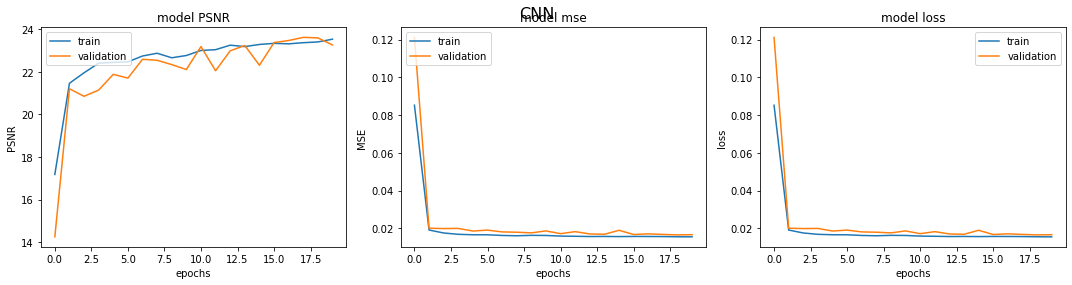

0.016688894480466843 0.016688894480466843 23.267860412597656


In [128]:
plot_history(history.history,model.name)

valid_loss, valid_mse, valid_psnr = model.evaluate(X_valid[:valid_size], Y_valid[:valid_size], batch_size=16, verbose=0)

print(valid_loss,valid_mse,valid_psnr)

---

## Visualization

In [129]:
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [130]:
def plot_comparison(img_resized,img_recolored, figsize=(7,3),cast=False):     
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    ax = axes.ravel()

    ax[0].imshow(img_resized.astype('uint8') if cast else img_resized)
    ax[0].set_title("Resized")
    
    ax[1].imshow(img_recolored)
    ax[1].set_title("Recolored")

    fig.tight_layout()
    plt.show()     

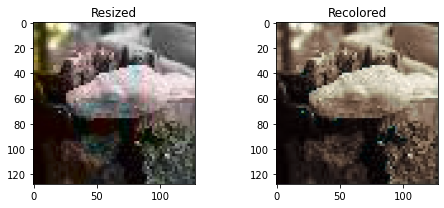

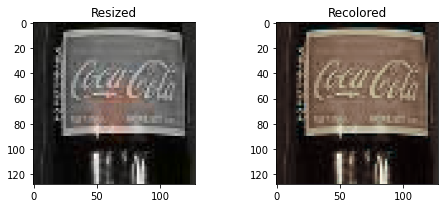

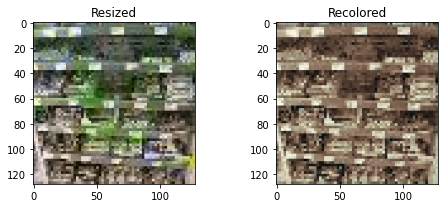

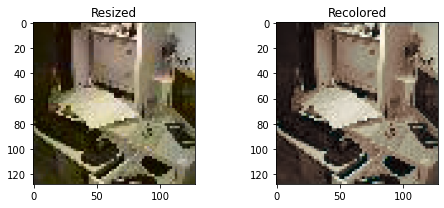

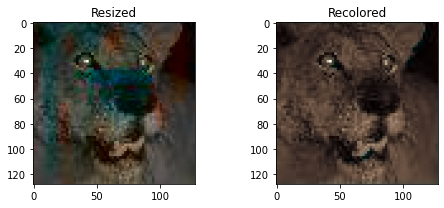

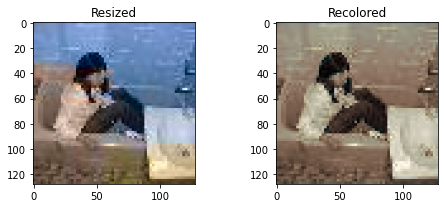

C:\Users\ghiot\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 15 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


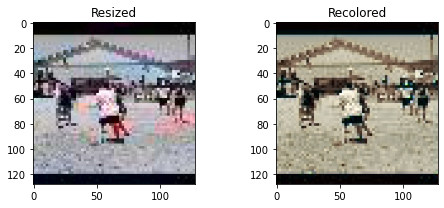

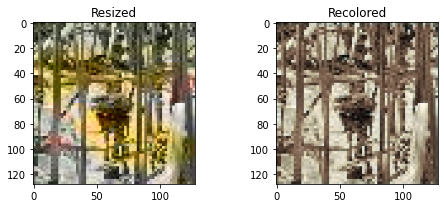

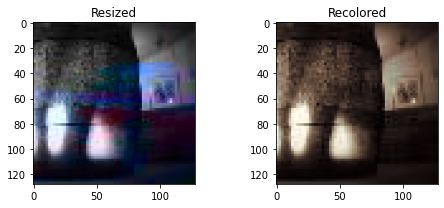

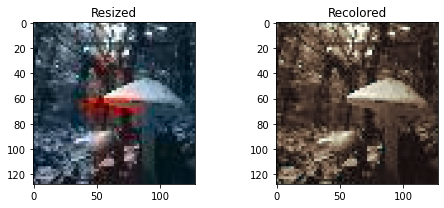

In [131]:
for i, x in enumerate(X_train[:10]):     
    
    img_color = []
    img_color.append(x)
    img_color = np.array(img_color, dtype=float)

    output = model.predict(img_color)
    output = output*128
    
    result = np.zeros((SIZE, SIZE, 3))
    result[:,:,0] = img_color[0][:,:,0]
    result[:,:,1:] = output[0]

    recolored = lab2rgb(result)
    
    original = np.zeros((SIZE, SIZE, 3))
    original[:,:,0] = x[:,:,0]
    original[:,:,1:] = Y_test[i]*128
    
    original = lab2rgb(original)
    
    plot_comparison(original, recolored)

C:\Users\ghiot\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 18 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


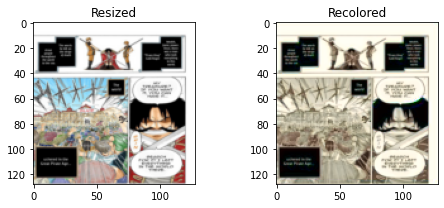

C:\Users\ghiot\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 17 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


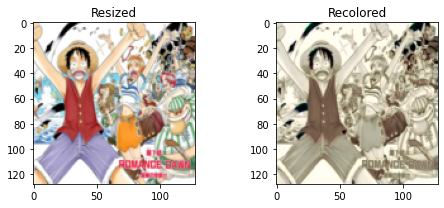

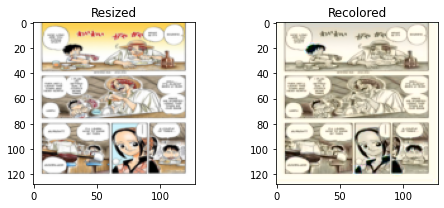

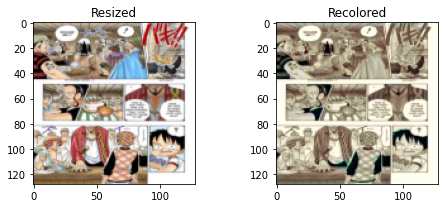

C:\Users\ghiot\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


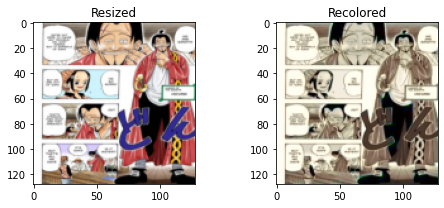

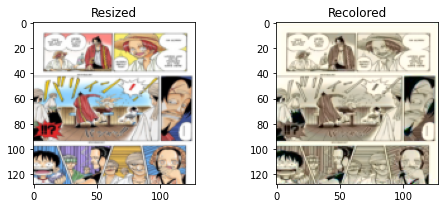

C:\Users\ghiot\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


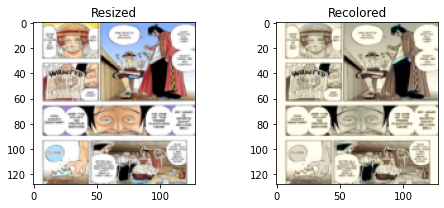

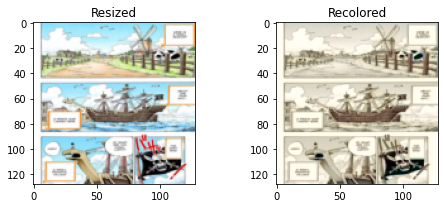

C:\Users\ghiot\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


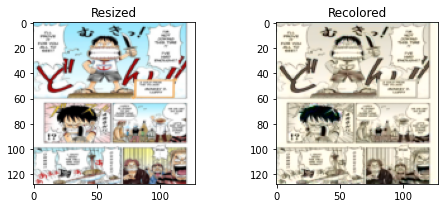

C:\Users\ghiot\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 19 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


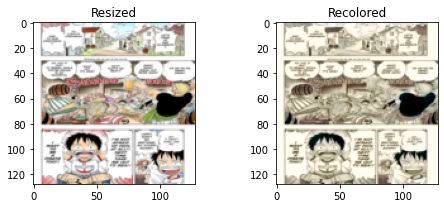

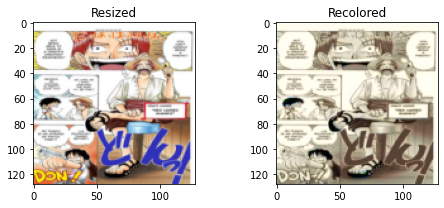

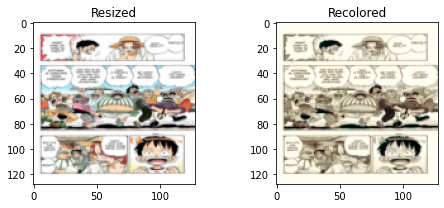

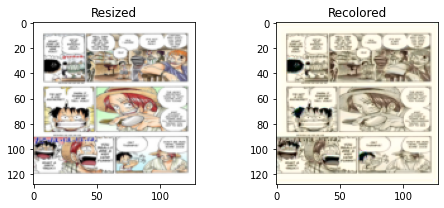

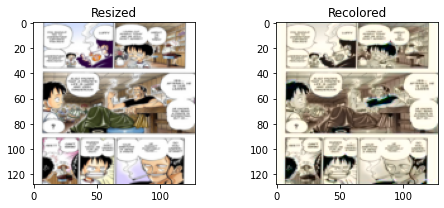

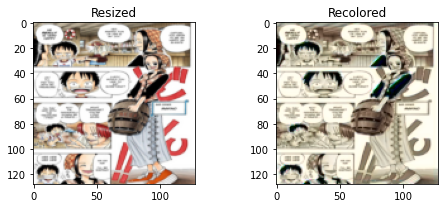

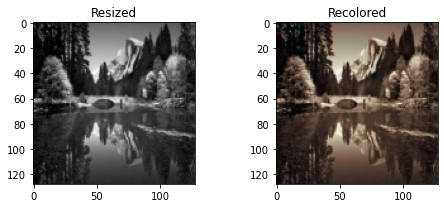

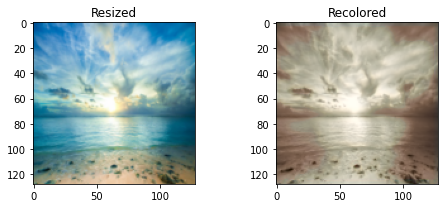

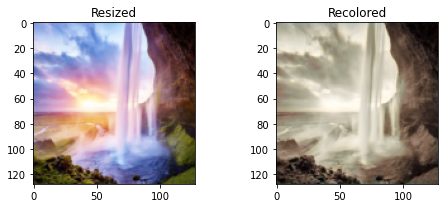

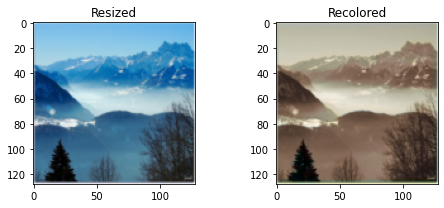

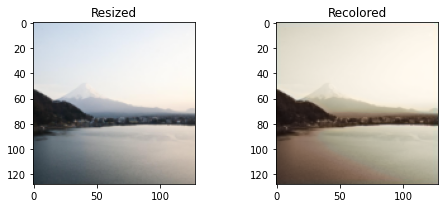

In [132]:
test_path = "../test/" # modify here to load images from a different folder

for i, img_path in enumerate(os.listdir(test_path)):    
    
    img_color = []
    img = img_to_array(load_img(test_path+img_path))
    original_shape = img.shape
    
    img = resize(img, (SIZE,SIZE))
    
    img_color.append(img)
    
    img_color = np.array(img_color, dtype=float)
    img_color = rgb2lab(1.0/255*img_color)[:,:,:,0]
    img_color = img_color.reshape(img_color.shape+(1,))

    output = model.predict(img_color)
    output = output*128
    
    result = np.zeros((SIZE, SIZE, 3))
    result[:,:,0] = img_color[0][:,:,0]
    result[:,:,1:] = output[0]

    recolored = lab2rgb(result)
    
    plot_comparison(img, recolored,cast=True)